# Planar Procrustes 2D Elastic Mean Estimation using ```elasdics```

```compute_elastic_mean()``` ::

Inputs : 
- data_curves: ```list``` of curves. Curves are ```dataframes``` with pairs of coordinates (X1,X2) ordered along the curve.
- knots: ```vector``` of knots in [0,1].
- scale: TRUE/FALSE
- rotation: TRUE/FALSE

Output :
- ```$type```: 'smooth' or 'polygon'
- ```$coefs```: matrix of points (X1, X2) of the mean curve at the knot positions (I guess?)
- ```$knots``` : ```vector of knots in [0,1] as specified in the input
- ```$data_curves``` : t, t_optim, Gamma, beta, (V1, V2)
- ```$closed``` : TRUE or FALSE
- ```$scale```: TRUE or FALSE
- ```$rotation```: TRUE or FALSE

## Algorithm
1. Create arc length parametrization for curves without 't' column.
2. Get SRV data curves
3. Compute Elastic Mean
    1. bla

#### Imports

In [106]:
# Load local datasets script.
source("../../scripts/load_datasets.R")

# Blablabla
library(ggplot2)
library(dplyr)

# required for procrustes means
library(mgcv)
library(shapeboost)

set.seed(18)

#### Inputs

In [107]:
data_curves <- curves.spiral(rotate=FALSE, scale=FALSE, center=TRUE)
knots <- seq(0,1, length = 11)

# Settings
type = "polygon"  # or "polygon"
closed = FALSE
eps = 0.01
pen_factor = 100
max_iter = 50

In [108]:
print(data_curves[[1]])

             X1          X2
1  -0.030041676  0.25858466
2  -0.179518615  0.26141802
3  -0.284249948 -0.00586670
4   0.008459451 -0.28550388
5   0.413786557 -0.03961088
6   0.251570531  0.52609276
7  -0.397001879  0.49968938
8  -0.747436716 -0.23465871
9  -0.245658631 -0.90256955
10  0.564805050 -0.56648950
11  0.645285875  0.48891439


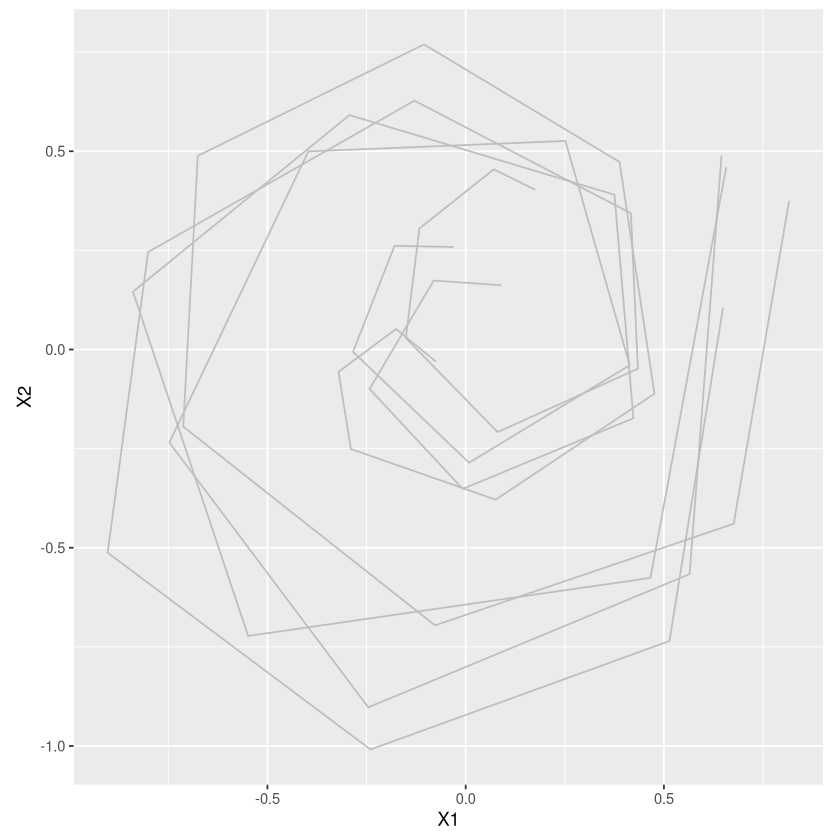

In [109]:
ggplot(bind_rows(data_curves, .id = "id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color ="grey") +
    coord_fixed()

## Calculate Elastic Procrustes 2D Mean
### 1. Create arc length parametrization if curves don't have 't' column.
For points $\vec{r}_j$ along curve, calculate
- length up to point $j \geq 1$:  $\quad l_j = \sum_{i=2}^j (\vec{r}_i - \vec{r}_{i-1})^2 = 
    \sum_{i=2}^j \sqrt{(r_{i, x} r_{i-1, x})^2 + (r_{i, y} - r_{i-1, y})^2}$ with $l_1 = 0$.
- total length: $\quad l = \sum_{j=1}^n l_j$
- arc length up to point $j$: $\quad t_j = \frac{l_j}{l}$

In [110]:
# Create arc length parametrization if curves don't have 't' column.
get_arc_length_param <- function (data_curve) 
{
    t_arc_length <- c(0, cumsum(sqrt(rowSums(apply(data_curve, 2, diff)^2))))
    t_arc_length <- t_arc_length/max(t_arc_length)
    t_arc_length
}


data_curves <- lapply(data_curves, function(data_curve) {
        if (!("t" %in% colnames(data_curve))) {
          data.frame(t = get_arc_length_param(data_curve), 
                     data_curve)
        }
        else {
          param <- data_curve$t
          data_curve$t <- NULL
          data.frame(t = param, data_curve)
        }
    })

In [111]:
print(data_curves[[1]])

            t           X1          X2
1  0.00000000 -0.030041676  0.25858466
2  0.02435705 -0.179518615  0.26141802
3  0.07112646 -0.284249948 -0.00586670
4  0.13707874  0.008459451 -0.28550388
5  0.21431579  0.413786557 -0.03961088
6  0.31019412  0.251570531  0.52609276
7  0.41594660 -0.397001879  0.49968938
8  0.54851042 -0.747436716 -0.23465871
9  0.68461251 -0.245658631 -0.90256955
10 0.82755515  0.564805050 -0.56648950
11 1.00000000  0.645285875  0.48891439


### 2. Get SRV data curves

The SRV representation of a curve $f(t)$ is given by $q(t) = \frac{\dot{f}(t)}{\sqrt{||\dot{f}(t)||}}$ and for the discrete case we use $\dot{f}(t) \approx \frac{\Delta f}{\Delta t}$.

For points $\vec{r}_j$ along curve, calculate $\vec{q}_j$ as the SRV-vector from point $j-1$ to $j$:
- $\Delta t = t_j - t_{j-1}$
- $\Delta f = f(t_j) - f(t_{j-1}) = \left( x(t_j) - x(t_{j-1}) \, , \, y(t_j) - y(t_{j-1}) \right)^T 
    = (\Delta x, \Delta y)^T$
- $\vec{q}_j = \left. \frac{\Delta f}{\Delta t} \middle/ \sqrt{ ||\frac{\Delta f}{\Delta t}|| } \right.
    = \Delta f \cdot \frac{1}{\Delta t} \cdot \frac{\sqrt{\Delta t}}{\sqrt{||\Delta f||}} 
    = \frac{1}{\sqrt{\Delta t}} \cdot \frac{1}{\sqrt{\sqrt{\Delta x^2 + \Delta y^2}}} \cdot \Delta f
    = \frac{1}{\sqrt{\Delta t}} \cdot (\Delta x^2 + \Delta y^2)^{0.25} \cdot \Delta f$

In [112]:
# Get SRV data curves
get_srv_from_points <- function (data_curve)
{
    data_points <- as.matrix(data_curve[, names(data_curve) != "t"])
    diff_points <- diff(data_points)
    factor <- 1/(sqrt(diff(data_curve$t)) * rowSums(diff_points^2)^0.25)
    srv_vectors <- factor * diff_points
    srv_data <- data.frame(t = data_curve$t[-nrow(data_curve)], srv_vectors)
    srv_data
}

srv_data_curves <- lapply(data_curves, get_srv_from_points)

In [113]:
print(srv_data_curves[[1]])

            t         X1          X2
1  0.00000000 -2.4770555  0.04695304
2  0.02435705 -0.9038597 -2.30673933
3  0.07112646  1.7914021 -1.71139921
4  0.13707874  2.1181964  1.28501074
5  0.21431579 -0.6829038  2.38152285
6  0.31019412 -2.4754501 -0.10077555
7  0.41594660 -1.0670101 -2.23595577
8  0.54851042  1.4881035 -1.98079694
9  0.68461251  2.2885374  0.94900216
10 0.82755515  0.1883772  2.47032846


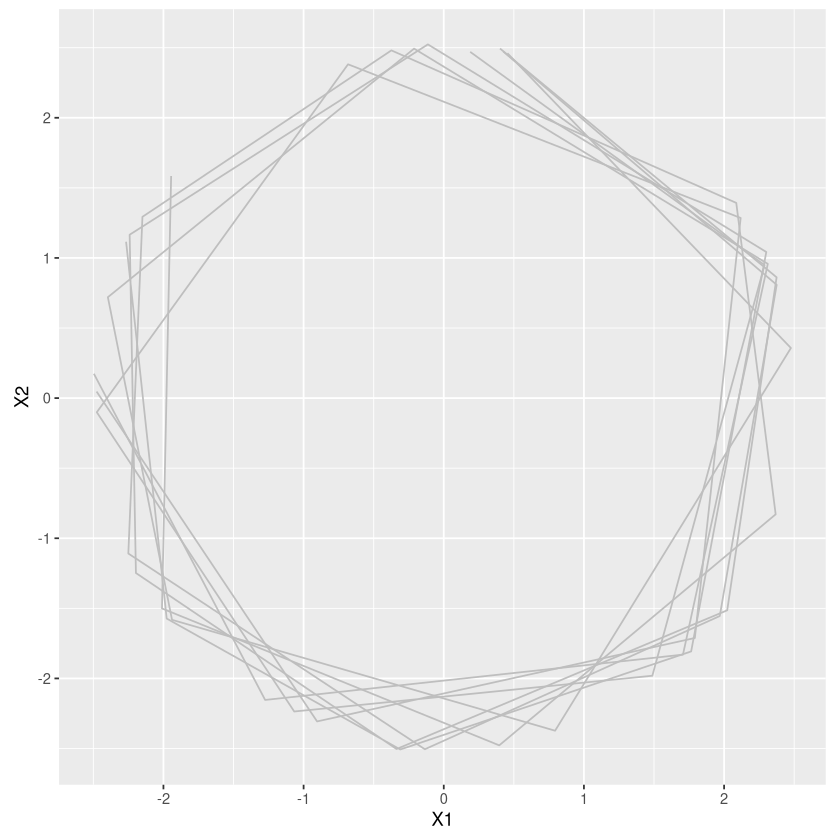

In [114]:
ggplot(bind_rows(srv_data_curves, .id = "id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color ="grey") +
    coord_fixed()

### 3. Fit Elastic Procrustes Mean

The ```fit_mean``` function calculates the optimal parametrization ```t_optims``` and the mean ```coefs```.

In [118]:
t_optims <- lapply(srv_data_curves, function(srv_data_curve) {
    c(srv_data_curve$t, 1)
})
coefs <- 0

#### A. Fit Mean
1. Get Model data
- Calculate new, reparameterized srv data vectors $\vec{q}_{new}(t)$ from ```t_optim```:
    - $\vec{q}_{new}(t) 
        = \left. \frac{\Delta f}{\Delta t_{new}} \middle/ \sqrt{||\frac{\Delta f}{\Delta t_{new}}||} \right.
        = \left. \frac{\Delta f}{\Delta t} \middle/ \sqrt{||\frac{\Delta f}{\Delta t}||} \right. 
            \cdot \frac{\Delta t}{\Delta t_{new}} \sqrt{\frac{\Delta t_{new}}{\Delta t}}
        = \vec{q}(t) \cdot \sqrt{\frac{\Delta t}{\Delta t_{new}}}$

- Define SRV parametrization (t for the data curve, m for the srv data curve!)
    - if smooth: m is the center between the t_optims.
    - if polygon: ... ?
    
- Output in long format

In [120]:
get_model_data <- function (t_optims, srv_data_curves, knots, type) 
{
    
    # Calculate new, reparameterized srv data vectors from t_optim.
    q_m_data <- lapply(1:length(srv_data_curves), function(j) {
        old_diff <- diff(c(srv_data_curves[[j]]$t, 1))
        new_diff <- diff(t_optims[[j]])
        as.matrix(srv_data_curves[[j]][, -1]) * sqrt(old_diff/new_diff)
    })
    
    if (type == "polygon") {
        # If type == 'polygon': Define m as ... ?
        q_m_all <- lapply(1:length(srv_data_curves), function(j) {
            # For each knot find the ... ?
            q_m_knots <- sapply(knots[-length(knots)], function(knot) {
                idx_knot <- findInterval(knot, t_optims[[j]], rightmost.closed = T)
                q_m_data[[j]][idx_knot, ]
            })
            q_knots <- data.frame(t = knots[-length(knots)], t(q_m_knots))
            
            topt <- t_optims[[j]][-1] - 0.5 * diff(t_optims[[j]])
            t_edge <- c(0, sapply(seq_along(t), function(i){
                t_full <- c(0,t,1)
                js <- seq(1,i)
                t[i] <<- t[i] + (t_full[i+1] - t_full[i])
            }))
            
            
            q_data <- data.frame(t = t_optims[[j]][-length(t_optims[[j]])], q_m_data[[j]])
            data <- rbind(q_knots, q_data)
            unique(data[order(data$t), ])
        })
        m <- lapply(q_m_all, function(x) {
            c(x$t[-1], 1) - 0.5 * diff(c(x$t, 1))
        })
        q_m <- lapply(q_m_all, function(x) x[, -1])
    }
    else {
        # If type == 'smooth': Define m as the center between the t_optims.
        m <- lapply(t_optims, function(t_optim) {
            t_optim[-1] - 0.5 * diff(t_optim)
        })
        q_m <- q_m_data
    }
    m_long <- do.call(c, m)
    q_m_long <- do.call(rbind, q_m)
    data.frame(m_long = m_long, q_m_long = q_m_long)
}

In [121]:
model_data <- get_model_data(t_optims, srv_data_curves, knots, type)

In [128]:
print(if_else(type == "smooth", model_data[1:10,], model_data[1:10,]))

ERROR: Error in `[.data.frame`(true, rep(NA_integer_, length(condition))): undefined columns selected


2. Make Design

In [56]:
library(splines)

make_design <- function (t, knots, closed = FALSE, type = "smooth") 
{
    deg <- ifelse(type == "smooth", 1, 0)
    design_mat <- splineDesign(
        knots = c(rep(0, deg), knots, rep(1, deg)),
        x = t, 
        outer.ok = TRUE, 
        ord = deg + 1
    )
    if (closed == TRUE & type == "smooth") {
        design_mat[, 1] <- design_mat[, 1] + design_mat[, ncol(design_mat)]
        design_mat <- design_mat[, -ncol(design_mat)]
    }
    design_mat
}

  3. Fit Mean

- Split $\vec{q}(m)$ into $x(m)$ and $y(m)$ and estimate means seperately.
- Estimate mean as linear model:
    - $\hat{x}(m) = \sum_i^{knots} \hat{\beta}_i \cdot \phi_i(m)$
    - with b-spline basis functions of degree 1 $\quad \phi_i(m)$

In [129]:
coefs_old <- coefs
# Mean are the Coefs from a Linear Model.
coefs <- apply(model_data[, -1], 2, function(q_m_x_long) {
    q_m_x_long[!is.finite(q_m_x_long)] <- NA
    coef(lm(q_m_x_long ~ -1 + make_design(model_data[,1], knots = knots, closed = FALSE, type = type)))
})

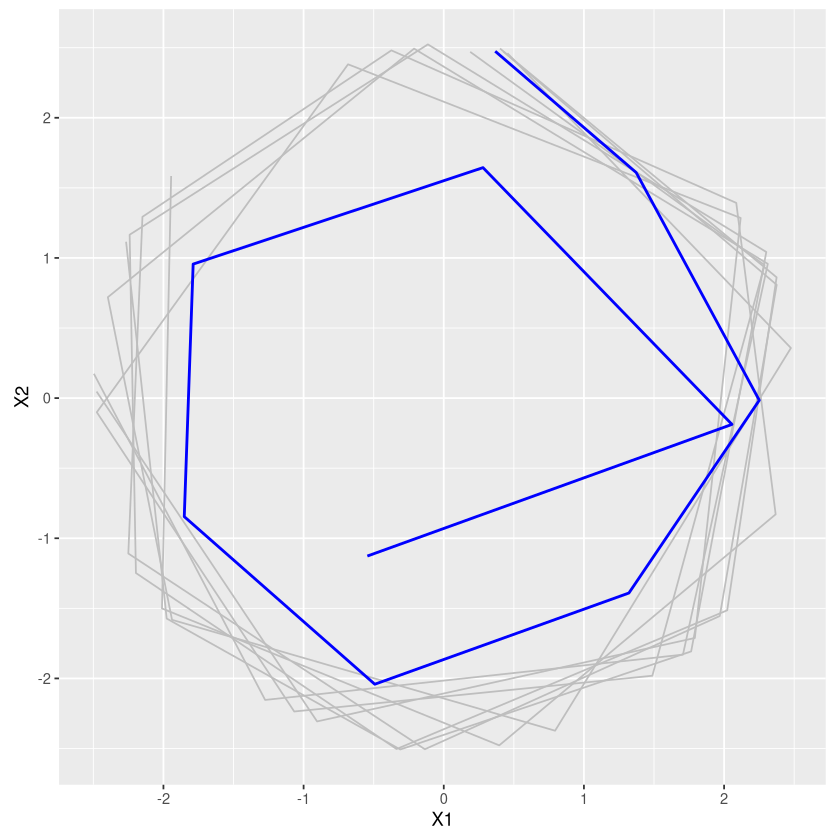

In [130]:
ggplot() + 
    geom_path(data=bind_rows(srv_data_curves, .id = "id"), aes(x=X1, y=X2, group=id), size=0.5, color ="grey") +
    geom_path(data=data.frame(coefs), aes(x=q_m_long.X1, y=q_m_long.X2), size=0.8, color = "blue") +
    coord_fixed()

#### B. Calculate Stopping Criterion

In [131]:
stop_crit <- sum((coefs - coefs_old)^2)/sum(coefs^2)
if (stop_crit > eps) {
    warning("Stopping criterion not reached!")
    }

Warning message in eval(expr, envir, enclos):
“Stopping criterion not reached!”


#### C. Compute t_optims

For ```type```: 'smooth'
* pfun: evaluate mean function at discrete *t* (note: actually *t* should be called *m* here, as we have srv mean!):
    * $\texttt{pfun}(t) = \sum_{i=1}^{knots} \hat{\beta}_i \cdot \phi_i(t)$

In [139]:
i = 1
# pfun evalutes the mean function on the specified t!
pfun <- function(t) {
    t(make_design(t, knots = knots, closed = FALSE, type = type) %*% coefs)
}

# Calculate new t_optims. Takes: srv_data-curves, and mean (as function!)
if(type == "smooth"){
    t_optims <- lapply(1:length(srv_data_curves), function(j) {
        t_optim <- elasdics:::find_optimal_t(
            srv_curve = pfun,
            s = c(srv_data_curves[[j]]$t, 1), 
            q = t(srv_data_curves[[j]][, -1]), 
            initial_t = t_optims[[j]], 
            eps = eps * 100/i
        )
        attr(t_optim, "dist_to_mean") <- attr(t_optim, "dist")
        attr(t_optim, "dist") <- NULL
        t_optim
    })
}

For ```type```: 'polygon'

In [140]:
if(type == "polygon"){
    # Calculate new t_optims
    t_optims <- lapply(1:length(srv_data_curves), function(j) {
        t_optim <- elasdics:::find_optimal_t_discrete(
            r = knots,
            p = t(coefs),
            s = c(srv_data_curves[[j]]$t, 1),
            q = t(srv_data_curves[[j]][, -1]), 
            initial_t = t_optims[[j]]
        )
        attr(t_optim, "dist_to_mean") <- attr(t_optim, "dist")
        attr(t_optim, "dist") <- NULL
        t_optim
    })
}

In [141]:
print(t_optims[[1]])

 [1] 0.000000000 0.008403808 0.100000000 0.144717616 0.200000000 0.309166540
 [7] 0.500000000 0.600000000 0.700000000 0.896930165 1.000000000
attr(,"dist_to_mean")
[1] 1.096412


In [143]:
model_data <- get_model_data(t_optims, srv_data_curves, knots, type)
print(model_data[1:20,])

        m_long q_m_long.X1 q_m_long.X2
1  0.004201904 -4.21706237  0.07993519
12 0.054201904 -0.64586722 -1.64831702
2  0.122358808  2.17554803 -2.07838944
14 0.172358808  2.50371956  1.51888960
3  0.250000000 -0.63999267  2.23187679
4  0.304583270 -0.63999267  2.23187679
16 0.354583270 -1.84277445 -0.07501933
5  0.450000000 -1.84277445 -0.07501933
6  0.550000000 -1.22851657 -2.57439815
7  0.650000000  1.73606326 -2.31085317
8  0.750000000  1.94976734  0.80852225
9  0.848465082  1.94976734  0.80852225
20 0.898465082  0.24366198  3.19531758
10 0.950000000  0.24366198  3.19531758
17 0.000000000 -1.83013348 -1.45596547
11 0.021900630        -Inf         Inf
13 0.071900630 -0.27348865 -2.20929166
23 0.119762379  2.02357372 -2.07205359
15 0.169762379  2.30796613  1.04533707
31 0.250000000 -0.08878466  1.97852648


#### Apply this iteratively until stopping criterion is reached!

In [67]:
fit_mean <- function (srv_data_curves, knots, max_iter, type, eps) 
{
    
    # Initialize Output
    t_optims <- lapply(srv_data_curves, function(srv_data_curve) {
        c(srv_data_curve$t, 1)
    })
    coefs <- 0
    
    
    for (i in 1:max_iter) {
        
        ################
        # Fit Mean Step!
        ################
        
        model_data <- get_model_data(t_optims, srv_data_curves, knots, type)
        
        coefs_old <- coefs
        
        # Mean are the Coefs from a Linear Model.
        coefs <- apply(model_data[, -1], 2, function(q_m_x_long) {
            q_m_x_long[!is.finite(q_m_x_long)] <- NA
            coef(lm(q_m_x_long ~ -1 + make_design(model_data[,1], knots = knots, closed = FALSE, type = type)))
        })
        
        
        #################
        # Stop Crit Step!
        #################
        
        stop_crit <- sum((coefs - coefs_old)^2)/sum(coefs^2)
        if (stop_crit < eps | max_iter == 0) {
            # ---> Return
            rownames(coefs) <- NULL
            colnames(coefs) <- colnames(srv_data_curves[[1]][,-1])
            return(list(type = type, coefs = coefs, knots = knots, t_optims = t_optims))
        }
        
        
        #######################
        # Compute t_optim step!
        #######################
        
        # For eastimating a smooth mean -> check if get_evals checks this!
        if (type == "smooth") {
            
            # pfun = fitted mean as a function of t
            pfun <- function(t) {
                t(make_design(t, knots = knots, closed = FALSE, type = type) %*% coefs)
            }
            
            # Calculate new t_optims
            t_optims <- lapply(1:length(srv_data_curves), function(j) {
                t_optim <- find_optimal_t(
                    srv_curve = pfun,
                    s = c(srv_data_curves[[j]]$t, 1), 
                    q = t(srv_data_curves[[j]][, -1]), 
                    initial_t = t_optims[[j]], 
                    eps = eps * 100/i
                )
                attr(t_optim, "dist_to_mean") <- attr(t_optim, "dist")
                attr(t_optim, "dist") <- NULL
                t_optim
            })
        }
        
        # For "polygon"/discrete? mean
        else {
            
            # Calculate new t_optims
            t_optims <- lapply(1:length(srv_data_curves), function(j) {
                t_optim <- find_optimal_t_discrete(
                    r = knots,
                    p = t(coefs),
                    s = c(srv_data_curves[[j]]$t, 1),
                    q = t(srv_data_curves[[j]][, -1]), 
                    initial_t = t_optims[[j]]
                )
                attr(t_optim, "dist_to_mean") <- attr(t_optim, "dist")
                attr(t_optim, "dist") <- NULL
                t_optim
            })
        }
    }
    # ---> Return (without reaching stopping criterion!)
    warning("Stopping criteria eps has not been reached! Consider more iterations max_iter")
    rownames(coefs) <- NULL
    colnames(coefs) <- colnames(srv_data_curves[[1]][, -1])
    return(list(type = type, coefs = coefs, knots = knots, t_optims = t_optims))
}


In [79]:
print(t)

 [1] 0.01658501 0.05918806 0.11744612 0.18903952 0.27493811 0.38047950
 [7] 0.50348148 0.63787287 0.77982748 0.92569825


In [104]:
t <- model_data[1:10,1]
t_edge <- c(0, sapply(seq_along(t), function(i){
    t_full <- c(0,t,1)
    js <- seq(1,i)
    t[i] <<- t[i] + (t_full[i+1] - t_full[i])
}))

In [105]:
t_edge

[1] 0.00000000 0.03317003 0.08520609 0.14968614 0.22839290 0.32148332
 [7] 0.43947567 0.56748729 0.70825846 0.85139649 1.00000000